In [1]:
#Mandatory imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
train = pd.read_json("input/train.json")
target_train=train['is_iceberg']
test = pd.read_json("input/test.json")

In [3]:
target_train=train['is_iceberg']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
train['inc_angle']=train['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
X_test_angle=test['inc_angle']

In [4]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
#X_band_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in train["inc_angle"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)

In [5]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
#X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

In [6]:
#Import Keras.
from matplotlib import pyplot
from keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [7]:
import cv2
def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images

In [8]:
X_train_more = get_more_images(X_train)

In [9]:
target_train_more = np.concatenate((target_train, target_train, target_train))

In [10]:
X_train_more.shape

(4812, 75, 75, 3)

In [11]:
target_train_more.shape

(4812,)

In [12]:
X_angle_more = np.concatenate((X_angle, X_angle, X_angle))

In [13]:
X_test_angle_more = np.concatenate((X_test_angle, X_test_angle, X_test_angle))

In [14]:
#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

In [15]:
# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

In [16]:
# Finally create generator
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=15, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [17]:
def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train_more.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    

    x = GlobalMaxPooling2D()(x)
    merge_one = concatenate([x, angle_layer])
    merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(1, activation='sigmoid')(merge_one)
    
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=True)
    model.compile(loss='binary_crossentropy',
                    optimizer=adam,
                    metrics=['accuracy'])
    
#     sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
#     model.compile(loss='binary_crossentropy',
#                   optimizer=sgd,
#                   metrics=['accuracy'])
    return model



In [19]:
#def myAngleCV(X_train, X_angle, X_test):
K=10
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train_more, target_train_more))
y_test_pred_log = 0
y_train_pred_log=0
y_valid_pred_log = 0.0*target_train_more
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    X_train_cv = X_train_more[train_idx]
    y_train_cv = target_train_more[train_idx]
    X_holdout = X_train_more[test_idx]
    Y_holdout= target_train_more[test_idx]
    
    #Angle
    X_angle_cv=X_angle_more[train_idx]
    X_angle_hold=X_angle_more[test_idx]
    #define file path and get callbacks
    file_path = "%s_aug_model_weights.hdf5"%j
    callbacks = get_callbacks(filepath=file_path, patience=5)
    gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
    galaxyModel= getVggAngleModel()
    histr = galaxyModel.fit_generator(
            gen_flow,
            steps_per_epoch=24,
            epochs=100,
            shuffle=True,
            verbose=1,
            validation_data=([X_holdout,X_angle_hold], Y_holdout),
            callbacks=callbacks)
     #Getting the Best Model
    galaxyModel.load_weights(filepath=file_path)
    #Getting Training Score
    score = galaxyModel.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    #Getting Test Score
    score = galaxyModel.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    #Getting validation Score.
    pred_valid=galaxyModel.predict([X_holdout,X_angle_hold])
    y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

    #Getting Test Scores
    temp_test=galaxyModel.predict([X_test, X_test_angle_more])
    y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

    #Getting Train Scores
    temp_train=galaxyModel.predict([X_train_more, X_angle_more])
    y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

y_test_pred_log=y_test_pred_log/K
y_train_pred_log=y_train_pred_log/K

print('\n Train Log Loss Validation= ',log_loss(target_train_more, y_train_pred_log))
print(' Test Log Loss Validation= ',log_loss(target_train_more, y_valid_pred_log))
#return y_test_pred_log


===================FOLD= 0
Epoch 1/100
24/24 [==============================] - 17s 688ms/step - loss: 0.6160 - acc: 0.6621 - val_loss: 0.3418 - val_acc: 0.8402
Epoch 2/100
24/24 [==============================] - 16s 647ms/step - loss: 0.4249 - acc: 0.7793 - val_loss: 0.3179 - val_acc: 0.8402
Epoch 3/100
24/24 [==============================] - 15s 643ms/step - loss: 0.3027 - acc: 0.8586 - val_loss: 0.2754 - val_acc: 0.8734
Epoch 4/100
24/24 [==============================] - 16s 648ms/step - loss: 0.2831 - acc: 0.8652 - val_loss: 0.2543 - val_acc: 0.8983
Epoch 5/100
24/24 [==============================] - 14s 570ms/step - loss: 0.2725 - acc: 0.8750 - val_loss: 0.2686 - val_acc: 0.8963
Epoch 6/100
24/24 [==============================] - 15s 644ms/step - loss: 0.2534 - acc: 0.8850 - val_loss: 0.2521 - val_acc: 0.9315
Epoch 7/100
24/24 [==============================] - 14s 569ms/step - loss: 0.2494 - acc: 0.8906 - val_loss: 0.2531 - val_acc: 0.9046
Epoch 8/100
24/24 [===============

Epoch 21/100
24/24 [==============================] - 14s 571ms/step - loss: 0.2069 - acc: 0.9134 - val_loss: 0.2538 - val_acc: 0.9046
Epoch 22/100
24/24 [==============================] - 16s 651ms/step - loss: 0.1937 - acc: 0.9212 - val_loss: 0.1462 - val_acc: 0.9481
Epoch 23/100
24/24 [==============================] - 13s 561ms/step - loss: 0.1907 - acc: 0.9205 - val_loss: 0.1807 - val_acc: 0.9232
Epoch 24/100
24/24 [==============================] - 14s 570ms/step - loss: 0.1792 - acc: 0.9349 - val_loss: 0.1740 - val_acc: 0.9232
Epoch 25/100
24/24 [==============================] - 14s 570ms/step - loss: 0.1950 - acc: 0.9121 - val_loss: 0.1576 - val_acc: 0.9295
Epoch 26/100
24/24 [==============================] - 14s 566ms/step - loss: 0.1754 - acc: 0.9280 - val_loss: 0.1593 - val_acc: 0.9481
Epoch 27/100
24/24 [==============================] - 16s 649ms/step - loss: 0.1654 - acc: 0.9362 - val_loss: 0.1342 - val_acc: 0.9440
Epoch 28/100
24/24 [==============================] - 1

Epoch 82/100
24/24 [==============================] - 14s 566ms/step - loss: 0.0811 - acc: 0.9720 - val_loss: 0.0463 - val_acc: 0.9855
Epoch 83/100
24/24 [==============================] - 13s 559ms/step - loss: 0.0699 - acc: 0.9752 - val_loss: 0.0442 - val_acc: 0.9855
Epoch 84/100
24/24 [==============================] - 14s 566ms/step - loss: 0.0611 - acc: 0.9766 - val_loss: 0.0573 - val_acc: 0.9668
Epoch 85/100
24/24 [==============================] - 14s 566ms/step - loss: 0.0478 - acc: 0.9837 - val_loss: 0.0428 - val_acc: 0.9834
Epoch 86/100
24/24 [==============================] - 14s 567ms/step - loss: 0.0467 - acc: 0.9831 - val_loss: 0.0334 - val_acc: 0.9896
Epoch 87/100
24/24 [==============================] - 16s 646ms/step - loss: 0.0468 - acc: 0.9837 - val_loss: 0.0167 - val_acc: 0.9959
Epoch 88/100
24/24 [==============================] - 13s 559ms/step - loss: 0.0642 - acc: 0.9743 - val_loss: 0.0407 - val_acc: 0.9855
Epoch 89/100
24/24 [==============================] - 1

Epoch 42/100
24/24 [==============================] - 14s 569ms/step - loss: 0.1751 - acc: 0.9284 - val_loss: 0.1041 - val_acc: 0.9564
Epoch 43/100
24/24 [==============================] - 15s 642ms/step - loss: 0.1185 - acc: 0.9577 - val_loss: 0.0934 - val_acc: 0.9689
Epoch 44/100
24/24 [==============================] - 14s 567ms/step - loss: 0.1157 - acc: 0.9564 - val_loss: 0.1051 - val_acc: 0.9647
Epoch 45/100
24/24 [==============================] - 14s 568ms/step - loss: 0.1341 - acc: 0.9408 - val_loss: 0.0961 - val_acc: 0.9689
Epoch 46/100
24/24 [==============================] - 15s 642ms/step - loss: 0.1193 - acc: 0.9541 - val_loss: 0.0846 - val_acc: 0.9689
Epoch 47/100
24/24 [==============================] - 14s 568ms/step - loss: 0.1162 - acc: 0.9525 - val_loss: 0.0945 - val_acc: 0.9668
Epoch 48/100
24/24 [==============================] - 14s 569ms/step - loss: 0.0995 - acc: 0.9629 - val_loss: 0.0971 - val_acc: 0.9689
Epoch 49/100
24/24 [==============================] - 1

Epoch 62/100
24/24 [==============================] - 14s 567ms/step - loss: 0.0899 - acc: 0.9648 - val_loss: 0.1132 - val_acc: 0.9522
Epoch 63/100
24/24 [==============================] - 13s 561ms/step - loss: 0.0973 - acc: 0.9636 - val_loss: 0.0691 - val_acc: 0.9730
Epoch 64/100
24/24 [==============================] - 15s 646ms/step - loss: 0.0921 - acc: 0.9603 - val_loss: 0.0564 - val_acc: 0.9834
Epoch 65/100
24/24 [==============================] - 15s 644ms/step - loss: 0.0742 - acc: 0.9714 - val_loss: 0.0515 - val_acc: 0.9792
Epoch 66/100
24/24 [==============================] - 13s 557ms/step - loss: 0.0841 - acc: 0.9661 - val_loss: 0.0672 - val_acc: 0.9730
Epoch 67/100
24/24 [==============================] - 14s 566ms/step - loss: 0.1057 - acc: 0.9629 - val_loss: 0.0818 - val_acc: 0.9771
Epoch 68/100
24/24 [==============================] - 14s 565ms/step - loss: 0.0797 - acc: 0.9700 - val_loss: 0.0962 - val_acc: 0.9584
Epoch 69/100
24/24 [==============================] - 1

Epoch 82/100
24/24 [==============================] - 14s 566ms/step - loss: 0.0444 - acc: 0.9837 - val_loss: 0.0248 - val_acc: 0.9958
Epoch 83/100
24/24 [==============================] - 13s 559ms/step - loss: 0.0381 - acc: 0.9851 - val_loss: 0.0495 - val_acc: 0.9875
Epoch 84/100
24/24 [==============================] - 14s 565ms/step - loss: 0.0692 - acc: 0.9766 - val_loss: 0.0449 - val_acc: 0.9792
Epoch 85/100
24/24 [==============================] - 16s 647ms/step - loss: 0.0486 - acc: 0.9837 - val_loss: 0.0187 - val_acc: 0.9958
Epoch 86/100
24/24 [==============================] - 14s 566ms/step - loss: 0.0450 - acc: 0.9844 - val_loss: 0.0334 - val_acc: 0.9834
Epoch 87/100
24/24 [==============================] - 14s 567ms/step - loss: 0.0487 - acc: 0.9863 - val_loss: 0.0212 - val_acc: 0.9896
Epoch 88/100
24/24 [==============================] - 15s 641ms/step - loss: 0.0508 - acc: 0.9847 - val_loss: 0.0163 - val_acc: 0.9958
Epoch 89/100
24/24 [==============================] - 1

Epoch 42/100
24/24 [==============================] - 14s 568ms/step - loss: 0.1393 - acc: 0.9440 - val_loss: 0.1472 - val_acc: 0.9376
Epoch 43/100
24/24 [==============================] - 15s 643ms/step - loss: 0.1187 - acc: 0.9521 - val_loss: 0.1244 - val_acc: 0.9522
Epoch 44/100
24/24 [==============================] - 16s 648ms/step - loss: 0.1390 - acc: 0.9499 - val_loss: 0.1054 - val_acc: 0.9543
Epoch 45/100
24/24 [==============================] - 14s 566ms/step - loss: 0.1272 - acc: 0.9473 - val_loss: 0.1183 - val_acc: 0.9418
Epoch 46/100
24/24 [==============================] - 14s 563ms/step - loss: 0.1180 - acc: 0.9580 - val_loss: 0.1162 - val_acc: 0.9563
Epoch 47/100
24/24 [==============================] - 16s 647ms/step - loss: 0.1117 - acc: 0.9557 - val_loss: 0.0983 - val_acc: 0.9667
Epoch 48/100
24/24 [==============================] - 14s 566ms/step - loss: 0.1017 - acc: 0.9590 - val_loss: 0.1014 - val_acc: 0.9543
Epoch 49/100
24/24 [==============================] - 1

Epoch 62/100
24/24 [==============================] - 16s 646ms/step - loss: 0.0766 - acc: 0.9681 - val_loss: 0.0742 - val_acc: 0.9688
Epoch 63/100
24/24 [==============================] - 13s 559ms/step - loss: 0.0778 - acc: 0.9740 - val_loss: 0.2136 - val_acc: 0.9189
Epoch 64/100
24/24 [==============================] - 14s 567ms/step - loss: 0.1179 - acc: 0.9622 - val_loss: 0.1078 - val_acc: 0.9501
Epoch 65/100
24/24 [==============================] - 16s 646ms/step - loss: 0.0811 - acc: 0.9668 - val_loss: 0.0729 - val_acc: 0.9667
Epoch 66/100
24/24 [==============================] - 14s 563ms/step - loss: 0.0790 - acc: 0.9701 - val_loss: 0.0809 - val_acc: 0.9709
Epoch 67/100
24/24 [==============================] - 16s 648ms/step - loss: 0.0626 - acc: 0.9772 - val_loss: 0.0584 - val_acc: 0.9792
Epoch 68/100
24/24 [==============================] - 14s 565ms/step - loss: 0.0798 - acc: 0.9743 - val_loss: 0.0741 - val_acc: 0.9626
Epoch 69/100
24/24 [==============================] - 1

Epoch 22/100
24/24 [==============================] - 16s 650ms/step - loss: 0.1577 - acc: 0.9355 - val_loss: 0.1367 - val_acc: 0.9439
Epoch 23/100
24/24 [==============================] - 15s 645ms/step - loss: 0.1846 - acc: 0.9212 - val_loss: 0.1313 - val_acc: 0.9584
Epoch 24/100
24/24 [==============================] - 14s 569ms/step - loss: 0.1719 - acc: 0.9323 - val_loss: 0.1621 - val_acc: 0.9272
Epoch 25/100
24/24 [==============================] - 16s 650ms/step - loss: 0.1663 - acc: 0.9349 - val_loss: 0.1270 - val_acc: 0.9626
Epoch 26/100
24/24 [==============================] - 14s 564ms/step - loss: 0.1589 - acc: 0.9434 - val_loss: 0.1343 - val_acc: 0.9459
Epoch 27/100
24/24 [==============================] - 14s 570ms/step - loss: 0.1467 - acc: 0.9382 - val_loss: 0.1713 - val_acc: 0.9314
Epoch 28/100
24/24 [==============================] - 14s 570ms/step - loss: 0.1825 - acc: 0.9219 - val_loss: 0.1674 - val_acc: 0.9272
Epoch 29/100
24/24 [==============================] - 1


===================FOLD= 8
Epoch 1/100
24/24 [==============================] - 19s 778ms/step - loss: 0.8511 - acc: 0.6133 - val_loss: 0.3344 - val_acc: 0.8462
Epoch 2/100
24/24 [==============================] - 15s 642ms/step - loss: 0.5626 - acc: 0.7676 - val_loss: 0.2809 - val_acc: 0.8773
Epoch 3/100
24/24 [==============================] - 15s 636ms/step - loss: 0.3830 - acc: 0.8321 - val_loss: 0.2536 - val_acc: 0.9044
Epoch 4/100
24/24 [==============================] - 15s 643ms/step - loss: 0.4327 - acc: 0.8164 - val_loss: 0.2309 - val_acc: 0.9189
Epoch 5/100
24/24 [==============================] - 14s 563ms/step - loss: 0.3637 - acc: 0.8411 - val_loss: 0.2546 - val_acc: 0.8877
Epoch 6/100
24/24 [==============================] - 15s 638ms/step - loss: 0.2796 - acc: 0.8744 - val_loss: 0.2215 - val_acc: 0.9002
Epoch 7/100
24/24 [==============================] - 15s 643ms/step - loss: 0.3189 - acc: 0.8704 - val_loss: 0.2026 - val_acc: 0.9127
Epoch 8/100
24/24 [===============

Epoch 21/100
24/24 [==============================] - 15s 643ms/step - loss: 0.2245 - acc: 0.9023 - val_loss: 0.1565 - val_acc: 0.9437
Epoch 22/100
24/24 [==============================] - 13s 562ms/step - loss: 0.1650 - acc: 0.9290 - val_loss: 0.1647 - val_acc: 0.9417
Epoch 23/100
24/24 [==============================] - 13s 558ms/step - loss: 0.1939 - acc: 0.9265 - val_loss: 0.1597 - val_acc: 0.9313
Epoch 24/100
24/24 [==============================] - 14s 565ms/step - loss: 0.2355 - acc: 0.8932 - val_loss: 0.2197 - val_acc: 0.9104
Epoch 25/100
24/24 [==============================] - 15s 645ms/step - loss: 0.1874 - acc: 0.9212 - val_loss: 0.1418 - val_acc: 0.9458
Epoch 26/100
24/24 [==============================] - 13s 557ms/step - loss: 0.1511 - acc: 0.9383 - val_loss: 0.1569 - val_acc: 0.9333
Epoch 27/100
24/24 [==============================] - 13s 562ms/step - loss: 0.1676 - acc: 0.9316 - val_loss: 0.1482 - val_acc: 0.9354
Epoch 28/100
24/24 [==============================] - 1

Epoch 82/100
24/24 [==============================] - 15s 639ms/step - loss: 0.0701 - acc: 0.9792 - val_loss: 0.0354 - val_acc: 0.9896
Epoch 83/100
24/24 [==============================] - 13s 554ms/step - loss: 0.0557 - acc: 0.9766 - val_loss: 0.0722 - val_acc: 0.9750
Epoch 84/100
24/24 [==============================] - 13s 560ms/step - loss: 0.0469 - acc: 0.9857 - val_loss: 0.0395 - val_acc: 0.9854
Epoch 85/100
24/24 [==============================] - 13s 559ms/step - loss: 0.0533 - acc: 0.9818 - val_loss: 0.0417 - val_acc: 0.9813
Epoch 86/100
24/24 [==============================] - 13s 562ms/step - loss: 0.0540 - acc: 0.9831 - val_loss: 0.0658 - val_acc: 0.9771
Epoch 87/100
24/24 [==============================] - 13s 562ms/step - loss: 0.0877 - acc: 0.9661 - val_loss: 0.0950 - val_acc: 0.9625
Epoch 88/100
24/24 [==============================] - 13s 556ms/step - loss: 0.0774 - acc: 0.9705 - val_loss: 0.0378 - val_acc: 0.9833
Epoch 89/100
24/24 [==============================] - 1

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1662: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1662: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


In [20]:
#preds=myAngleCV(X_train, X_angle, X_test)
preds = y_test_pred_log

In [21]:
# Submission to kaggle
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub_Adam_10folds_amsgrad_0001_15p_4812.csv', index=False)

dict_keys(['acc', 'val_loss', 'loss', 'val_acc'])


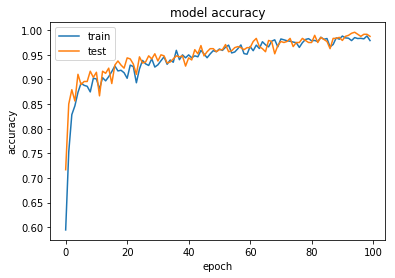

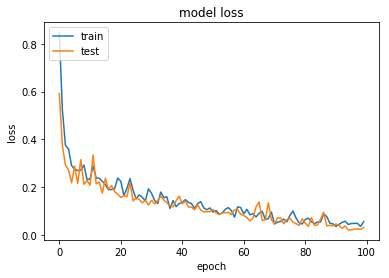

In [22]:
# list all data in history
print(histr.history.keys())
# summarize history for accuracy
plt.plot(histr.history['acc'])
plt.plot(histr.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histr.history['loss'])
plt.plot(histr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---

In [23]:
import matplotlib.image as mpimg

min1 = np.min(X_holdout)
max1 = np.max(X_holdout)
diff1 = max1 - min1
my_sum = lambda x: (x - min1)/diff1

X_holdout2 = my_sum(X_holdout)

In [49]:
np.info(Y_holdout)

class:  ndarray
shape:  (480,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x553ef700
byteorder:  little
byteswap:  False
type: int64


In [50]:
Y_holdout

array([1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1,

In [39]:
X_train_more.shape

(4812, 75, 75, 3)

In [40]:
X_train.shape

(1604, 75, 75, 3)

In [43]:
X_holdout2.shape

(480, 75, 75, 3)

In [56]:
pred_valid[0]

array([ 0.99658149], dtype=float32)

In [60]:
y_test_pred_log

array([  1.76173897e-04,   7.69077897e-01,   1.24053168e-03, ...,
         1.78735099e-05,   9.99964118e-01,   1.42175681e-03], dtype=float32)

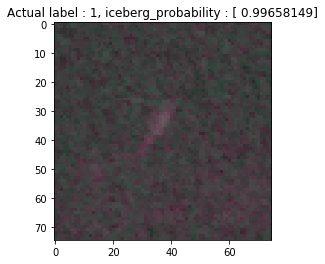

In [61]:
plt.imshow(X_holdout2[0], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[13])+ ","+" iceberg_probability : "+str(pred_valid[0])
plt.title(tl)

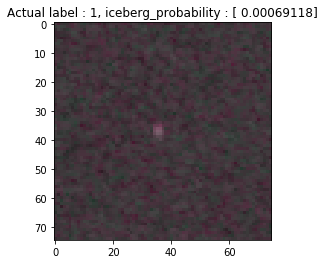

In [62]:
plt.imshow(X_holdout2[1], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[14])+ ","+" iceberg_probability : "+str(pred_valid[1])
plt.title(tl)

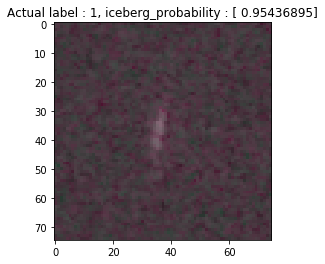

In [63]:
plt.imshow(X_holdout2[2], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[38])+ ","+" iceberg_probability : "+str(pred_valid[2])
plt.title(tl)

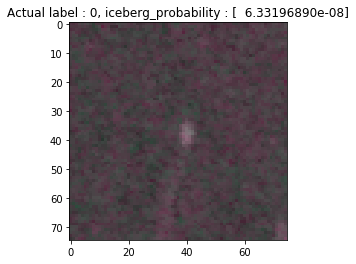

In [64]:
plt.imshow(X_holdout2[3], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[43])+ ","+" iceberg_probability : "+str(pred_valid[3])
plt.title(tl)

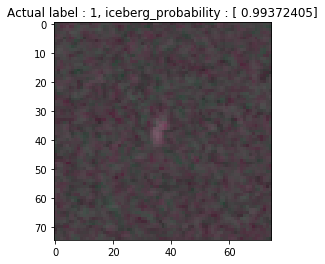

In [65]:
plt.imshow(X_holdout2[6], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[104])+ ","+" iceberg_probability : "+str(pred_valid[6])
plt.title(tl)

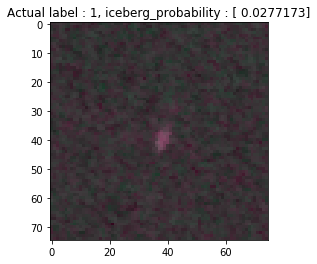

In [66]:
plt.imshow(X_holdout2[9], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[138])+ ","+" iceberg_probability : "+str(pred_valid[9])
plt.title(tl)

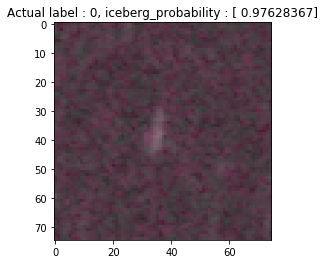

In [67]:
plt.imshow(X_holdout2[10], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[141])+ ","+" iceberg_probability : "+str(pred_valid[10])
plt.title(tl)

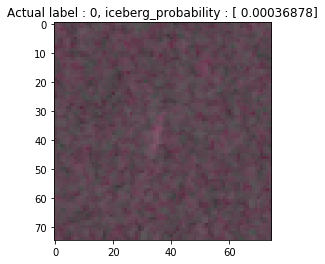

In [68]:
plt.imshow(X_holdout2[11], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[167])+ ","+" iceberg_probability : "+str(pred_valid[11])
plt.title(tl)

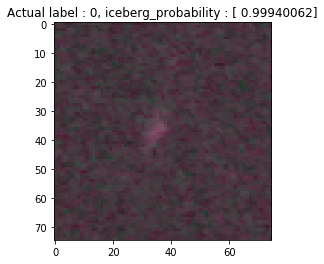

In [69]:
plt.imshow(X_holdout2[12], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[195])+ ","+" iceberg_probability : "+str(pred_valid[12])
plt.title(tl)

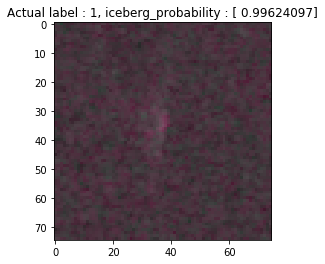

In [70]:
plt.imshow(X_holdout2[13], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[199])+ ","+" iceberg_probability : "+str(pred_valid[13])
plt.title(tl)